In [1]:
from network import *
from IQ_data_simulation import *

已生成蓝牙IQ文件: ../dataset/test1.iq
文件信息:
 - 采样率: 20.0 MHz
 - 持续时间: 0.1 秒
 - 样本数: 2000000
 - 文件大小: 15.26 MB (32位浮点IQ数据)


d:\Anaconda3\envs\bt\lib\site-packages\scipy\signal\_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,
f:\Bluetooth-RF-Fingerprint\model\IQ_data_simulation.py:133: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Sxx = signal.spectrogram(complex_signal, sample_rate, nperseg=256, noverlap=128)
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'd

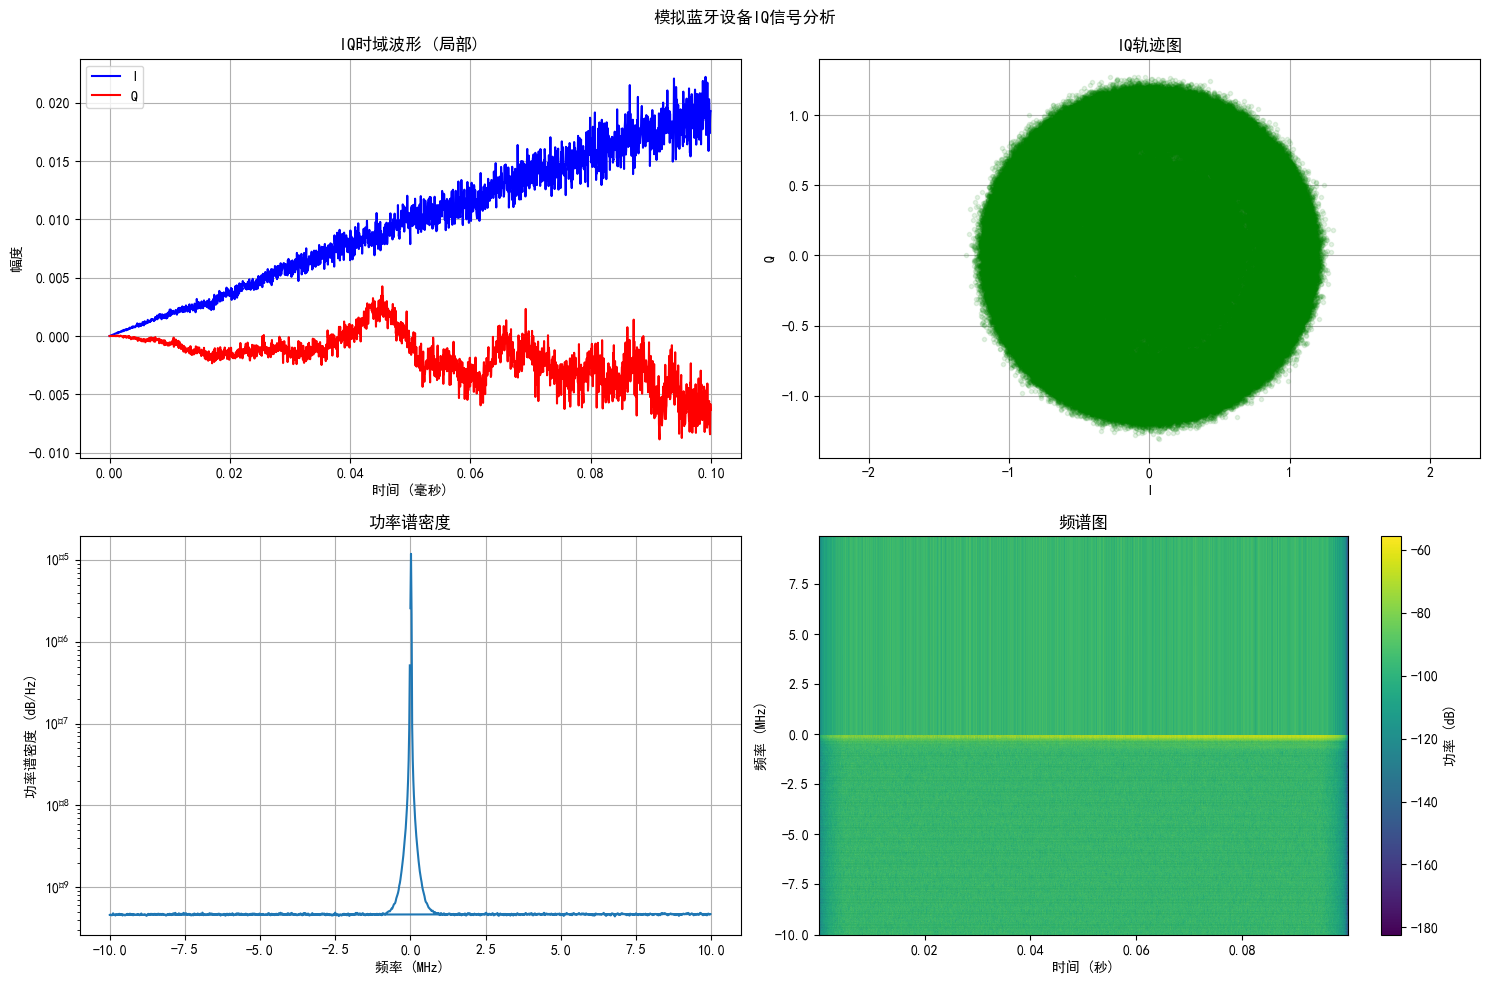

In [2]:
# 配置参数
sample_rate = 20e6  # 20 MHz采样率
duration = 0.1  # 0.5秒信号
output_file = "../dataset/test1.iq"
# output_file = "../dataset/bluetooth_device_signal.iq"

# 生成蓝牙IQ数据
i_data, q_data = generate_bluetooth_iq(output_file, duration, sample_rate)

# 绘制分析图表
plot_iq_data(i_data, q_data, sample_rate, "模拟蓝牙设备IQ信号分析")

In [4]:
# 加载模型和标准化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_features = 1024  # 与训练时相同
num_classes = 4  # 四种已知设备
model = create_model(num_features, num_classes).to(device)
model.load_state_dict(torch.load('./models/complex_cnn_model_250427.pth'))
scalers = torch.load('./models/scalers_250427.pth', weights_only=False)

In [5]:
# 使用模型预测未知设备
# data_file = "../dataset/raw data/bladerf/bladerf.iq"

confidence_threshold = 0.95  # 置信度阈值

# 读取数据
# data = load_iq_file(data_file)
data = load_iq_file(output_file)

# 分段数据
segment_length = 1024  # 与训练时相同
num_segments = len(data) // segment_length
segments = data[:num_segments * segment_length].reshape(num_segments, segment_length)

# 创建数据集和加载器
dataset = ComplexSignalDataset(segments, np.zeros(len(segments)), scalers[0], scalers[1])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# 预测
model.eval()
all_probs = []

with torch.no_grad():
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.vstack(all_probs)

# 获取最高概率及其对应的类别
max_probs = np.max(all_probs, axis=1)
predictions = np.argmax(all_probs, axis=1)

# 计算每个段的平均置信度
avg_confidence = np.mean(max_probs)

# 统计各类别的数量
unique, counts = np.unique(predictions, return_counts=True)
result = dict(zip(unique, counts))

# 映射到设备名称
device_names = ['bladerf', 'hackrf0', 'hackrf1', 'limesdr']
final_result = {device_names[int(k)]: v for k, v in result.items()}

# 判断是否为未知设备
if avg_confidence < confidence_threshold:
    device_type = "未知设备"
else:
    # 返回出现最多的设备类型
    majority_device = max(final_result, key=final_result.get)
    device_type = majority_device

In [6]:
print(f"预测的设备类型: {device_type}")
print(f"各类别的预测数量: {final_result}")
print(f"平均置信度: {avg_confidence:.4f}")

# 如果是已知设备，可以进一步分析
if device_type != "未知设备":
    print(f"这是一个已知设备: {device_type}")
else:
    print("这可能是一个训练数据中未包含的设备！")

预测的设备类型: 未知设备
各类别的预测数量: {'limesdr': 1953}
平均置信度: 0.6466
这可能是一个训练数据中未包含的设备！
